# Cell 1: Core Imports and Project Setup


In [1]:
# --- JAX, Flax, and Core Engine ---
import jax
import jax.numpy as jnp  
from jax import random, grad, value_and_grad, vmap, jit, hessian, lax
from jax.lax.linalg import qr
from jax.nn import relu
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
from jax import flatten_util
from flax import linen as nn
from typing import Sequence, Callable
from jax.lax import stop_gradient
# --- Optimizer ---
import optax  

# --- Custom "Crunch" Library ---
from Crunch.Models.layers import *
from Crunch.Models.polynomials import *
from Crunch.Auxiliary.metrics import *

# --- Data Handling and Utilities ---
import numpy as np   
import scipy
import scipy.io as sio
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange, tqdm
from functools import partial
import itertools
import sys
import os

In [2]:

import argparse
# Set up argument parser
parser = argparse.ArgumentParser(description='Tuning Parameters')
parser.add_argument('--vrba_potential_spatial', type=str, default='logarithmic', help='linear,exponential,quadratic,lp,cosh,logarithmic, superexp') #linear is no weights.
parser.add_argument('--problem', type=str, default='HPR', help='HPR, IPR, LPR')
parser.add_argument('--ngsteps', type=int, default=100000, help='In case')
parser.add_argument('--percentage_first_step', type=float, default=0.5, help='In case')

args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

METHOD=args.vrba_potential_spatial
METHOD_sample=args.vrba_potential_spatial
percentage_first_step=args.percentage_first_step

vrba_potential_spatial: logarithmic
problem: HPR
ngsteps: 100000
percentage_first_step: 0.5


In [3]:
# --- Configuration ---
Problem = args.problem  # Options: "HPR", "IPR", "LPR"
data_paths = {
    "HPR": "../data/high_pressure_ratio_LeBlanc/",
    "IPR": "../data/intermediate_pressure_ratio/",
    "LPR": "../data/low_pressure_ratio/"
}

base_path = data_paths[Problem]
train_file = base_path + "training_dataset.mat"
test_file = base_path + "testing_dataset.mat"

# --- Load and Combine Data ---
print(f"Loading {Problem} datasets...")

# 1. Load both .mat files
data_train = scipy.io.loadmat(train_file)
data_test  = scipy.io.loadmat(test_file)

# 2. Extract arrays (Numpy)
x_spatial = data_train['x']  # [nx, 1] (Spatial grid is shared)

# Train arrays
u_train_raw = data_train['utrain'] # [N_train, nx, 3]
v_train_raw = data_train['vtrain'] # [N_train, 1]

# Test arrays
u_test_raw = data_test['utest']    # [N_test, nx, 3]
v_test_raw = data_test['vtest']    # [N_test, 1]

print(f"Raw Shapes:")
print(f"  Train: u={u_train_raw.shape}, v={v_train_raw.shape}")
print(f"  Test:  u={u_test_raw.shape},  v={v_test_raw.shape}")

# 3. Concatenate (Mix) them into single arrays
print("\nMixing Training and Testing data...")
u_all_combined = np.concatenate([u_train_raw, u_test_raw], axis=0)
v_all = np.concatenate([v_train_raw, v_test_raw], axis=0)

# --- Process Density Only ---

# Shape: [N_total, nx]
rho_all = u_all_combined[:, :, 0]

print(f"\nProcessing Density (rho)...")
print(f"  rho_all shape before transform: {rho_all.shape}")

# Optional: Log transform for HPR
if Problem == "HPR":
    print("  Applying log transform to density (HPR case)...")
    rho_all = np.log(rho_all + 1e-10)
    print("  ✓ Log transform applied.")

print(f"\nFinal Numpy array shapes:")
print(f"  x_spatial: {x_spatial.shape}")
print(f"  rho_all:   {rho_all.shape}")
print(f"  v_all:     {v_all.shape}")

Loading HPR datasets...
Raw Shapes:
  Train: u=(400, 200, 3), v=(400, 1)
  Test:  u=(100, 200, 3),  v=(100, 1)

Mixing Training and Testing data...

Processing Density (rho)...
  rho_all shape before transform: (500, 200)
  Applying log transform to density (HPR case)...
  ✓ Log transform applied.

Final Numpy array shapes:
  x_spatial: (200, 1)
  rho_all:   (500, 200)
  v_all:     (500, 1)


In [4]:
# ============================================================
# CELL 7: NORMALIZATION (INSERT THIS CELL)
# ============================================================

print("\n" + "="*80)
print("NORMALIZING DATA")
print("="*80)

# --- 1. Compute min/max for INPUT (left pressure) ---
v_min = np.min(v_all)
v_max = np.max(v_all)

print(f"\nInput (left pressure) range:")
print(f"  Original: [{v_min:.4e}, {v_max:.4e}]")

# --- 2. Compute min/max for OUTPUT (density) ---
rho_min = np.min(rho_all)
rho_max = np.max(rho_all)

print(f"\nOutput (density) range:")
print(f"  Original: [{rho_min:.4e}, {rho_max:.4e}]")

print("\nApplying [-1, 1] normalization...")

# Normalize input
v_all_norm = 2.0 * (v_all - v_min) / (v_max - v_min + 1e-10) - 1.0

# Normalize output
rho_all_norm = 2.0 * (rho_all - rho_min) / (rho_max - rho_min + 1e-10) - 1.0
    
print("✓ Normalization complete!")

# --- 4. Verify normalized ranges ---
print(f"\nVerification:")
print(f"  v_all_norm:   [{np.min(v_all_norm):.4f}, {np.max(v_all_norm):.4f}]")
print(f"  rho_all_norm: [{np.min(rho_all_norm):.4f}, {np.max(rho_all_norm):.4f}]")

# --- 5. Store normalization parameters (for denormalization later) ---
norm_params = {
    'v_min': float(v_min), 
    'v_max': float(v_max),
    'rho_min': float(rho_min), 
    'rho_max': float(rho_max),
    'Problem': Problem
}

print(f"\nNormalization parameters stored for denormalization.")

# --- 6. Replace original arrays with normalized versions ---
v_all = v_all_norm
rho_all = rho_all_norm

print(f"\nData ready for JAX conversion!")


NORMALIZING DATA

Input (left pressure) range:
  Original: [1.0000e+09, 9.9820e+09]

Output (density) range:
  Original: [-6.9078e+00, 6.9315e-01]

Applying [-1, 1] normalization...
✓ Normalization complete!

Verification:
  v_all_norm:   [-1.0000, 1.0000]
  rho_all_norm: [-1.0000, 1.0000]

Normalization parameters stored for denormalization.

Data ready for JAX conversion!


In [5]:

print("\n" + "="*80)
print("CONVERTING TO JAX FLOAT32 (CRITICAL!)")
print("="*80)

# STEP 1: Convert numpy → JAX with explicit float32
f_all = jnp.array(v_all, dtype=jnp.float32)
y_all = jnp.array(x_spatial, dtype=jnp.float32)
s_all = jnp.array(rho_all, dtype=jnp.float32)

print(f"\nAfter JAX conversion:")
print(f"  f_all type: {type(f_all)}, dtype: {f_all.dtype}, shape: {f_all.shape}")
print(f"  y_all type: {type(y_all)}, dtype: {y_all.dtype}, shape: {y_all.shape}")
print(f"  s_all type: {type(s_all)}, dtype: {s_all.dtype}, shape: {s_all.shape}")



CONVERTING TO JAX FLOAT32 (CRITICAL!)

After JAX conversion:
  f_all type: <class 'jaxlib.xla_extension.ArrayImpl'>, dtype: float32, shape: (500, 1)
  y_all type: <class 'jaxlib.xla_extension.ArrayImpl'>, dtype: float32, shape: (200, 1)
  s_all type: <class 'jaxlib.xla_extension.ArrayImpl'>, dtype: float32, shape: (500, 200)


In [6]:

# Calculate the sizes for each split
train_size = 0.8

# First, split off the training data (still JAX arrays)
s_train, s_test, f_train, f_test = train_test_split(
    s_all, f_all, 
    train_size=train_size, 
    random_state=42
)

# CRITICAL: Ensure float32 after split (sklearn might change dtype!)
s_train = jnp.asarray(s_train, dtype=jnp.float32)
s_test = jnp.asarray(s_test, dtype=jnp.float32)
f_train = jnp.asarray(f_train, dtype=jnp.float32)
f_test = jnp.asarray(f_test, dtype=jnp.float32)
y_train = jnp.asarray(y_all, dtype=jnp.float32)

# Verify dtypes AGAIN (critical!)
print("\n" + "="*80)
print("AFTER TRAIN/TEST SPLIT - DTYPE VERIFICATION")
print("="*80)
print(f"f_train: type={type(f_train)}, dtype={f_train.dtype}, shape={f_train.shape}")
print(f"y_train: type={type(y_train)}, dtype={y_train.dtype}, shape={y_train.shape}")
print(f"s_train: type={type(s_train)}, dtype={s_train.dtype}, shape={s_train.shape}")
print(f"f_test:  type={type(f_test)}, dtype={f_test.dtype}, shape={f_test.shape}")
print(f"s_test:  type={type(s_test)}, dtype={s_test.dtype}, shape={s_test.shape}")

# Final assertions
assert f_train.dtype == jnp.float32, "f_train not float32!"
assert y_train.dtype == jnp.float32, "y_train not float32!"
assert s_train.dtype == jnp.float32, "s_train not float32!"
assert f_test.dtype == jnp.float32, "f_test not float32!"
assert s_test.dtype == jnp.float32, "s_test not float32!"

print("✓ All dtypes are float32!")

# Get number of samples
n_samples = f_train.shape[0] 
print(f"\nNumber of training samples: {n_samples}")

# Create data dictionaries
X_DN = {
    'F': f_train,
    'y': y_train,
    'S': s_train,
}

X_Test = {
    'F': f_test,
    'y': y_train,
    'S': s_test,
}

X_DN['X_Test'] = X_Test

print("\nData dictionaries created successfully!")
print(f"  X_DN['F']: {X_DN['F'].shape}, dtype={X_DN['F'].dtype}")
print(f"  X_DN['y']: {X_DN['y'].shape}, dtype={X_DN['y'].dtype}")
print(f"  X_DN['S']: {X_DN['S'].shape}, dtype={X_DN['S'].dtype}")

# ============================================================
# ADDITIONAL DIAGNOSTIC
# ============================================================

print("\n" + "="*80)
print("FINAL PRE-TRAINING CHECKS")
print("="*80)


AFTER TRAIN/TEST SPLIT - DTYPE VERIFICATION
f_train: type=<class 'jaxlib.xla_extension.ArrayImpl'>, dtype=float32, shape=(400, 1)
y_train: type=<class 'jaxlib.xla_extension.ArrayImpl'>, dtype=float32, shape=(200, 1)
s_train: type=<class 'jaxlib.xla_extension.ArrayImpl'>, dtype=float32, shape=(400, 200)
f_test:  type=<class 'jaxlib.xla_extension.ArrayImpl'>, dtype=float32, shape=(100, 1)
s_test:  type=<class 'jaxlib.xla_extension.ArrayImpl'>, dtype=float32, shape=(100, 200)
✓ All dtypes are float32!

Number of training samples: 400

Data dictionaries created successfully!
  X_DN['F']: (400, 1), dtype=float32
  X_DN['y']: (200, 1), dtype=float32
  X_DN['S']: (400, 200), dtype=float32

FINAL PRE-TRAINING CHECKS


In [7]:
# Run_Type
Run_type='Train'
# Model Architecture
N=840
m=100
num_layer=6
width_layer=100
embed_dim=m
# Initialize model
branch_layers = num_layer*[width_layer] +[embed_dim]
trunk_layers =  num_layer*[width_layer] +[embed_dim]
print(branch_layers)
print(trunk_layers)

# Optimization
ngsteps=args.ngsteps # Number of gradient steps.
batch_size=3000
lr=1e-3
decay_steps=5000
decay_rate=0.99
# Random Seeds
rng_branch = random.PRNGKey(1234)
rng_trunk = random.PRNGKey(4321)

# --- vRBA PARAMETERS ---
gamma=0.999
eta = 0.01
max_RBA0 = 10.0
phi_vRBA = 0.5
c_log = 1.0 
vRBA_hyperparams=phi_vRBA, c_log, gamma, eta, max_RBA0

###--- QR--DeepONet
ngsteps_stage1 = int(ngsteps *percentage_first_step)


[100, 100, 100, 100, 100, 100, 100]
[100, 100, 100, 100, 100, 100, 100]


In [8]:
class SVD_DeepONetModel(nn.Module):
    branch_layers: Sequence[int]
    trunk_layers: Sequence[int]
    N_fx: int  
    activation: Callable = nn.tanh

    def setup(self):
        self.branch_net = Adaptive_Activations_MLP(layers=self.branch_layers,
                              activation=self.activation)
        self.trunk_net = Adaptive_Activations_MLP(layers=self.trunk_layers,
                             activation=self.activation)
        
        embed_dim = self.trunk_layers[-1]
        A_init = jax.nn.initializers.variance_scaling(
            scale=1.0, mode='fan_in', distribution='truncated_normal'
        )
        self.A = self.param('A', A_init, (embed_dim, self.N_fx))

    def apply_stage1(self, y):
        Phi = self.trunk_net(y)
        return Phi, self.A

    def apply_stage2(self, F):
        C = self.branch_net(F)
        return C

    @nn.compact
    def __call__(self, F, y):
        """
        Defines the forward pass for PREDICTION/INFERENCE.
        This uses the SVD-based prediction: U_pred = C @ Q.T
        """
        C = self.branch_net(F)
        Phi = self.trunk_net(y)
        
        # Use JAX's SVD decomposition
        U, S, Vt = jnp.linalg.svd(Phi, full_matrices=False)
        Q = U  # Left singular vectors = orthonormal basis
        U_pred = C @ Q.T
        
        return U_pred

In [9]:
class MLP(nn.Module):
    features: Sequence[int]
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.Dense(feat)(x)
            x = self.activation(x)
        x = nn.Dense(self.features[-1])(x)
        return x

In [10]:
class Adaptive_Activations_MLP(nn.Module):
    layers: Sequence[int]
    activation: Callable = nn.tanh
    
    @nn.compact
    def __call__(self, x):
        # Glorot initialization with extra scaling (like original)
        def scaled_init(key, shape, dtype=jnp.float32):  # ← ADD dtype parameter
            in_dim, out_dim = shape
            std = jnp.sqrt(2.0 / (in_dim + out_dim))
            return jax.nn.initializers.glorot_normal()(key, shape, dtype) * std
        
        H = x
        
        # Hidden layers with adaptive activations
        for idx, feat in enumerate(self.layers[:-1]):
            # Learnable parameters for this layer
            a = self.param(f'a_{idx}', lambda rng: jnp.full((1,), 0.1))
            c = self.param(f'c_{idx}', lambda rng: jnp.full((1,), 0.1))
            a1 = self.param(f'a1_{idx}', lambda rng: jnp.full((1,), 0.0))
            F1 = self.param(f'F1_{idx}', lambda rng: jnp.full((1,), 0.1))
            c1 = self.param(f'c1_{idx}', lambda rng: jnp.full((1,), 0.0))
            
            # Dense layer
            H = nn.Dense(feat, kernel_init=scaled_init, use_bias=True)(H)
            
            # Adaptive activation: tanh + sin
            H = nn.tanh(10*a*H + c) + 10*a1*jnp.sin(10*F1*H + c1)
        
        # Output layer (no activation)
        H = nn.Dense(self.layers[-1], kernel_init=scaled_init, use_bias=True)(H)
        
        return H

In [11]:
print("Initializing model...")
# --- 1. Initialize New Model ---
model = SVD_DeepONetModel(branch_layers=branch_layers,
                           trunk_layers=trunk_layers,
                           N_fx=n_samples)

key = jax.random.PRNGKey(1234)
sample_F = X_DN['F']
sample_y = X_DN['y']


params = model.init(key, sample_F, sample_y) # This is a FrozenDict
_, unravel_fn = ravel_pytree(params)

# --- 2. Initialize Partitioned Optimizers (PINN-style) ---
print("Initializing partitioned optimizers (dynamic keys)...")

# Create a dictionary for optimizers
optimizers = {}
# Create a dictionary for states
states = {}

# Define schedules (can be customized per key)
lr_branch = lr * 0.5
lr_trunk = lr * 1.0
lr_A = lr * 1.2  # Learning rate for the A matrix

schedule_branch = optax.exponential_decay(lr_branch, decay_steps, decay_rate)
schedule_trunk = optax.exponential_decay(lr_trunk, decay_steps, decay_rate)
schedule_A = optax.exponential_decay(lr_A, decay_steps, decay_rate)

# Iterate over the keys in the 'params' sub-tree
# We now have 'branch_net', 'trunk_net', and 'A'
for key in params['params'].keys():
    if key == 'branch_net':
        print(f"Assigning branch optimizer to key: {key}")
        optimizers[key] = optax.adam(learning_rate=schedule_branch)
    elif key == 'trunk_net':
        print(f"Assigning trunk optimizer to key: {key}")
        optimizers[key] = optax.adam(learning_rate=schedule_trunk)
    elif key == 'A':
        print(f"Assigning A optimizer to key: {key}")
        optimizers[key] = optax.adam(learning_rate=schedule_A)
    else:
        # Fallback for any other parameters (e.g., 'batch_stats' if using BatchNorm)
        print(f"Assigning default optimizer to key: {key}")
        optimizers[key] = optax.adam(learning_rate=lr) 

# Populate the states dictionary
for key in optimizers.keys():
    states[key] = optimizers[key].init(params['params'][key])

itercount = itertools.count()

# --- 3. Create JIT-compiled Apply Functions ---
apply_fn = jax.jit(model.apply) 

# apply_fn for Stage 1 Loss
apply_stage1_fn = partial(model.apply, method='apply_stage1')
apply_stage1_fn = jax.jit(apply_stage1_fn)

apply_stage2_fn = partial(model.apply, method='apply_stage2')
apply_stage2_fn = jax.jit(apply_stage2_fn)

from jax.flatten_util import ravel_pytree

# You already have this line in your code:
flat_params, unravel_fn = ravel_pytree(params)

print(f"Total number of parameters: {flat_params.size}")

Initializing model...


Initializing partitioned optimizers (dynamic keys)...
Assigning A optimizer to key: A
Assigning branch optimizer to key: branch_net
Assigning trunk optimizer to key: trunk_net
Total number of parameters: 161660


In [36]:
@partial(jit, static_argnums=(2, 3))
def get_exact_epsilon(values, r_max, potential_type, n_newton=5):
    """
    Solves for the exact epsilon satisfying the variational constraint
    using a robust Newton-Raphson method.
    """
    N = values.shape[0]
    
    r_max_safe = jnp.maximum(r_max, 1e-8)
    
    # 1. Initialization (Asymptotic Approximations)
    if potential_type == 'cosh':
        # Constraint: mean(sinh(r/eps)) = 1
        # Approx: 1/N * 0.5 * exp(r_max/eps) = 1
        eps_guess = r_max_safe / (jnp.log(2.0 * N) + 1e-8)
        
    elif potential_type == 'superexp':

        eps_guess = r_max_safe / jnp.sqrt(jnp.log(N) + 1e-8)
    elif potential_type == 'logarithmic':
        eps_guess = jnp.mean(values) / (jnp.e - 1.0)
        eps_guess = jnp.maximum(eps_guess, 1e-8)        
    else:
        return 1.0 # Should not happen

    # 2. Newton Step Definition
    def newton_step(i, eps):
        # Add a tiny floor to eps inside division just in case intermediate step goes rogue
        eps_safe = jnp.maximum(eps, 1e-10)
        u = values / eps_safe
        
        if potential_type == 'cosh':
            # Target: mean(sinh(u)) - 1 = 0
            s_val = jnp.sinh(u)
            c_val = jnp.cosh(u)
            val = jnp.mean(s_val) - 1.0
            # Derivative: mean(cosh(u) * -u/eps)
            grad = jnp.mean(c_val * (-u / eps_safe))
            
        elif potential_type == 'superexp':
            # Target: mean(u * exp(u^2)) - 1 = 0
            exp_u2 = jnp.exp(u**2)
            term = u * exp_u2
            val = jnp.mean(term) - 1.0
            grad = jnp.mean(-(1.0 / eps_safe) * term * (1.0 + 2.0 * u**2))
        elif potential_type == 'logarithmic':
            val = jnp.mean(jnp.log(u + 1.0)) - 1.0
            grad = jnp.mean( -(1.0 / eps_safe) * u / (u + 1.0) )        
        else:
             # Fallback for jit compatibility
             val = 0.0
             grad = 1.0
            
        return eps - val / (grad - 1e-16) # Avoid div by zero in update

    # 3. Run Solver
    # lax.fori_loop(0, n, body, init) runs body n times.
    epsilon_final = lax.fori_loop(0, n_newton, newton_step, eps_guess)
    
    # SAFETY 2: Final output floor
    # We never want to return a practically zero epsilon to the weight update
    return jnp.maximum(epsilon_final, 1e-8)


# --- 1. Spatial Weight Update ---
def update_spatial_weights(R, Lambda_batch, it, gamma, eta,
                           phi=1.0, c_log=1.0, potential_type='exponential', p_val=4.0):
    """
    Batch-compatible vRBA spatial weight update.
    Integrates all 6 potential types with specific epsilon scaling rules.
    """
    R = stop_gradient(R)
    r_i = jnp.abs(R) # Shape: (batch_size, n_points)
    
    # Pre-calculate Max for scaling/initialization
    # Note: We handle the batch dimension for the exact solver using vmap
    r_max = jnp.max(r_i, axis=1, keepdims=True)

    if potential_type == 'exponential':
        # Logarithmic Annealing
        epsilon_q = c_log * r_max / jnp.log(it + 2.0)
        beta_it = 1.0 / (epsilon_q + 1e-20)
        q_it = jnp.exp(beta_it * r_i)
        
    elif potential_type == 'cosh':
        solve_fn = lambda r, rm: get_exact_epsilon(r, rm, 'cosh', 20) # 5 steps max
        epsilon_q = jax.vmap(solve_fn)(r_i, r_max.squeeze(-1))
        epsilon_q = epsilon_q[..., None] # Restore dims for broadcast
        
        beta_it = 1.0 / (epsilon_q + 1e-20)
        q_it = jnp.sinh(beta_it * r_i)

    elif potential_type == 'superexp':
        solve_fn = lambda r, rm: get_exact_epsilon(r, rm, 'superexp', 20) # 5 steps max
        epsilon_q = jax.vmap(solve_fn)(r_i, r_max.squeeze(-1))
        epsilon_q = epsilon_q[..., None]
        
        beta_it = 1.0 / (epsilon_q + 1e-20)
        u = beta_it * r_i
        q_it = u * jnp.exp(u**2)

    elif potential_type == 'logarithmic_simple':
        # Mean Scaling for Entropic Potential
        # epsilon ~ mean(r)
        epsilon_q = jnp.mean(r_i, axis=1, keepdims=True) / (jnp.e - 1.0)
        beta_it = 1.0 / (epsilon_q + 1e-20)
        # q ~ ln(r/eps + 1)
        q_it = jnp.log(beta_it * r_i + 1.0)

    elif potential_type == 'logarithmic':
        solve_fn = lambda r, rm: get_exact_epsilon(r, rm, 'logarithmic', 20)
        epsilon_q = jax.vmap(solve_fn)(r_i, r_max.squeeze(-1))
        epsilon_q = epsilon_q[..., None]
        beta_it = 1.0 / (epsilon_q + 1e-20)
        # Use shifted log to ensure weights >= 0
        q_it = jnp.log(beta_it * r_i + 1.0)

    elif potential_type == 'lp':
        # Generic Lp: q ~ r^(p-1)
        q_it = jnp.power(r_i, p_val - 1.0)
        
    elif potential_type == 'quadratic': 
        # Variance Minimization: q ~ r
        q_it = r_i

    elif potential_type == 'linear': 
        # No Adaptation: q ~ 1
        q_it = jnp.ones_like(r_i)
        return q_it

    else:
        print('Error potential unavailable')

    q_normalized = q_it / (jnp.max(q_it, axis=1, keepdims=True) + 1e-20)
    lambda_it = phi * q_normalized + (1.0 - phi)
    
    # 4. Update EMA
    new_Lambda = gamma * Lambda_batch + eta * lambda_it
    return new_Lambda


# --- 2. Function Sampling PDF Update ---
@partial(jit, static_argnums=(2, 3, 4, 5))
def update_function_pdf(Lambda_global, it,
                        phi=1.0, c_log=1.0, potential_type='exponential', p_val=4.0):
    """
    vRBA function sampling PDF.
    """
    Lambda_global = stop_gradient(Lambda_global)
    lambda_scores = jnp.sum(Lambda_global, axis=1) # Shape (n_samples,)
    r_max = jnp.max(lambda_scores)
    
    if potential_type == 'exponential':
        epsilon_q = c_log * r_max / jnp.log(it + 2.0)
        beta_it = 1.0 / (epsilon_q + 1e-20)
        q_it = jnp.exp(beta_it * lambda_scores)
        
    elif potential_type == 'cosh':
        # EXACT SOLVER (Scalar version, no vmap needed)
        epsilon_q = get_exact_epsilon(lambda_scores, r_max, 'cosh', 5)
        beta_it = 1.0 / (epsilon_q + 1e-20)
        q_it = jnp.sinh(beta_it * lambda_scores)

    elif potential_type == 'superexp':
        # EXACT SOLVER
        epsilon_q = get_exact_epsilon(lambda_scores, r_max, 'superexp', 5)
        beta_it = 1.0 / (epsilon_q + 1e-20)
        u = beta_it * lambda_scores
        q_it = u * jnp.exp(u**2)


    elif potential_type == 'logarithmic_simple':
        r_i=lambda_scores
        log_mean_r = jnp.mean(jnp.log(r_i + 1e-6))
        epsilon_q = jnp.exp(log_mean_r-1)
        beta_it = 1.0 / (epsilon_q + 1e-6)
        q_it = jnp.log(beta_it * r_i)

    elif potential_type == 'logarithmic':
        epsilon_q = get_exact_epsilon(lambda_scores, r_max, 'logarithmic', 5)
        beta_it = 1.0 / (epsilon_q + 1e-20)
        q_it = jnp.log(beta_it * lambda_scores + 1.0)

    elif potential_type == 'lp':
        q_it = jnp.power(lambda_scores, p_val - 1.0)
        
    elif potential_type == 'quadratic': 
        q_it = lambda_scores
        
    elif potential_type == 'linear': 
        q_it = jnp.ones_like(lambda_scores)
        
    else: 
        q_it = jnp.ones_like(lambda_scores)

    # 3. Normalize to PDF (Sum to 1)
    q_max_norm = q_it / (jnp.max(q_it) + 1e-20) 
    lambda_it = phi * q_max_norm + (1.0 - phi)
    q_pdf = lambda_it / jnp.sum(lambda_it)
    
    return q_pdf

# --- Hyperparameters & Baking (Unchanged) ---
def get_gamma(eta, max_RBA):
    gamma_it = 1.0 - eta / max_RBA
    return gamma_it

# Assuming vRBA_hyperparams, METHOD, METHOD_sample, ngsteps are defined in global scope
phi_vRBA, c_log, gamma, eta, max_RBA0 = vRBA_hyperparams
gamma_it = get_gamma(eta, max_RBA0)
Lambda_max = eta / (1.0 - gamma_it + 1e-16)

cap_RBA = 40 
step_RBA = (cap_RBA - max_RBA0) / (ngsteps / 10.0 - 1.0)

weighting_potential = METHOD 
sampling_potential = METHOD_sample 

print(f"Baking generic vRBA functions with method {weighting_potential} potential in space/latent and {sampling_potential} in function space")

weight_update_fn_baked = partial(
    update_spatial_weights,
    phi=phi_vRBA, 
    c_log=c_log, 
    potential_type=weighting_potential,
    p_val=4.0
)

function_pdf_fn_baked_and_jitted = partial(
    update_function_pdf,
    phi=phi_vRBA, 
    c_log=c_log, 
    potential_type=sampling_potential,
    p_val=4.0
)

Baking generic vRBA functions with method logarithmic potential in space/latent and logarithmic in function space


In [37]:
phi, c_log, gamma, eta, max_RBA0 = vRBA_hyperparams
gamma_it = get_gamma(eta, max_RBA0)
Lambda_max = eta / (1.0 - gamma_it + 1e-16)

Lambda_spatial = jnp.ones_like(X_DN['S']) * Lambda_max / 2.0
print(f"Initialized Lambda_spatial (Stage 1) with shape: {Lambda_spatial.shape}")

n_samples = X_DN['S'].shape[0]
Lambda_latent = jnp.ones((n_samples, embed_dim)) * Lambda_max / 2.0
print(f"Initialized Lambda_latent (Stage 2) with shape: {Lambda_latent.shape}")


cap_RBA = 40 # You can set this here
step_RBA = (cap_RBA - max_RBA0) / (ngsteps / 10.0 - 1.0)

Initialized Lambda_spatial (Stage 1) with shape: (400, 200)
Initialized Lambda_latent (Stage 2) with shape: (400, 100)


In [38]:
print(f"Baking generic vRBA functions with method {weighting_potential} potential in space/latent and {sampling_potential} in function space")

weight_update_fn_baked = partial(
    update_spatial_weights,
    phi=phi, 
    c_log=c_log, 
    potential_type=weighting_potential
)

function_pdf_fn_baked_and_jitted = partial(
    update_function_pdf,
    phi=phi, 
    c_log=c_log, 
    potential_type=sampling_potential
)

Baking generic vRBA functions with method logarithmic potential in space/latent and logarithmic in function space


# Cell 9: QR-DeepONet Loss Functions

This cell defines the two separate loss functions required for the `QR_DeepONetModel`'s two-stage training. Each function calculates one of the two residuals we identified in Cell 8 (Alt).

---
### 1. `loss_stage1` (Trunk + A)

This function computes the vRBA-weighted loss for the **spatial residual**.

* **Call:** It uses `apply_stage1_fn` to get the learned basis $ \mathbf{\Phi} $ (`Phi`) and the auxiliary matrix $ \mathbf{A} $ (`A`).
* **Residual:** It computes the spatial residual $ R1 = \Phi A - U^T $.
* **vRBA:** It calls the generic `weight_update_fn_baked` using this residual $ R1 $ and the `Lambda_spatial_all` state.
* **Return:** It returns the vRBA-weighted loss `jnp.mean((new_Lambda_spatial * R1_T)**2)` and the updated state `new_Lambda_spatial`.

---
### 2. `loss_stage2` (Branch)

This function computes the vRBA-weighted loss for the **latent residual**.

* **Call:** It uses `apply_stage2_fn` to get the coefficients $ \mathbf{C} $ (`C_all`) from the branch network.
* **Residual:** It computes the latent residual $ R2 = C - \text{Target} $ (where `Target_all` is the pre-computed $ R^* A^* $).
* **vRBA:** It calls the *same* generic `weight_update_fn_baked` using *this* residual $ R2 $ and the `Lambda_latent_all` state.
* **Return:** It returns the vRBA-weighted loss `jnp.mean((new_Lambda_latent * R2)**2)` and the updated state `new_Lambda_latent`.

---
### Summary for Agent

* This cell provides the two distinct loss functions for the two-stage training.
* `loss_stage1` is used to train the `'trunk_net'` and `'A'` parameters.
* `loss_stage2` is used to train the `'branch_net'` parameters.
* The `planner_agent` must ensure that the main training loop calls these two functions *separately* and updates the correct parameters for each stage.
"""

In [39]:
def loss_stage1(params, apply_stage1_fn, y, U_all_T, Lambda_spatial_all, 
                it, current_gamma, eta, weight_update_fn_baked):
    """
    Computes the vRBA-weighted loss for Stage 1 (Trunk + A) using the FULL dataset.
    """
    Phi, A = apply_stage1_fn(params, y)
    Pred = Phi @ A # Shape: (N_points, N_samples)
    R1 = Pred - U_all_T    
    R1_T = R1.T
    new_Lambda_spatial = weight_update_fn_baked(R1_T, Lambda_spatial_all, it,
                                                current_gamma, eta)
    
    loss = jnp.mean((new_Lambda_spatial * R1_T)**2)
    
    return loss, new_Lambda_spatial

def loss_stage2(params, apply_stage2_fn, F_all, Target_all, Lambda_latent_all,
                it, current_gamma, eta, weight_update_fn_baked):
    """
    Computes the vRBA-weighted loss for Stage 2 (Branch) using the FULL dataset.
    """
    C_all = apply_stage2_fn(params, F_all)
    R2 = C_all - Target_all
    new_Lambda_latent = weight_update_fn_baked(R2, Lambda_latent_all, it,
                                               current_gamma, eta)
    
    loss = jnp.mean((new_Lambda_latent * R2)**2)    
    return loss, new_Lambda_latent

### Cell 10: QR-DeepONet Gradient and Update Functions

This cell contains the JIT-compiled "engine" functions for the two-stage training loop.

---
### 1. Two-Stage Gradient Computation

Instead of a single `compute_grads_and_loss` function, we now have two, each one tailored to a specific training stage.

* **`compute_grads_stage1`**:
    * This is a JIT-compiled wrapper around `loss_stage1`.
    * It uses `jax.value_and_grad` to get the loss value, the updated `new_Lambda_spatial`, and the gradient PyTree `g`.
    * Crucially, this gradient `g` will have non-zero values only for the `'trunk_net'` and `'A'` parameters, as the `'branch_net'` is "invisible" to `loss_stage1`.

* **`compute_grads_stage2`**:
    * This is a JIT-compiled wrapper around `loss_stage2`.
    * It uses `jax.value_and_grad` to get the loss value, the updated `new_Lambda_latent`, and the gradient PyTree `g`.
    * This gradient `g` will have non-zero values only for the `'branch_net'` parameters.

---
### 2. `update_model` (Reusable)

This function is **identical** to the one used in the standard DeepONet notebook. This is a key advantage of the partitioned optimizer design (Cell 7, Alt).

Because `update_model` is designed to update any specific sub-tree (`key_params`) of the `params` PyTree, it can be reused perfectly here.

* In **Stage 1**, we will call it twice:
    * `update_model('trunk_net', ...)`
    * `update_model('A', ...)`
* In **Stage 2**, we will call it once:
    * `update_model('branch_net', ...)`

---
### Summary for Agent

* This cell provides the JIT-compiled gradient functions for the two-stage loop.
* The `planner_agent` must ensure the new training loop calls `compute_grads_stage1` for the Stage 1 update and `compute_grads_stage2` for the Stage 2 update.
* The `update_model` function is generic and will be used by both stages to update their respective parameters.
"""

In [40]:
# --- 1. Compute Grads for STAGE 1 (Trunk + A) ---
@partial(jit, static_argnums=(1, 2, 8)) # loss_fn, apply_fn, baked_fn are static
def compute_grads_stage1(params, loss_fn, apply_fn,
                         y, U_all_T, Lambda_spatial_all,
                         it, current_gamma,
                         weight_update_fn_baked):
    
    # This wrapper passes the arguments needed by loss_stage1
    def loss_wrapper(p):
        return loss_fn(p, apply_fn, y, U_all_T, Lambda_spatial_all, it,
                       current_gamma, eta, weight_update_fn_baked)
    
    (loss_value, new_Lambda_spatial), g = jax.value_and_grad(loss_wrapper, has_aux=True)(params)
    
    return loss_value, new_Lambda_spatial, g

@partial(jit, static_argnums=(1, 2, 8)) # loss_fn, apply_fn, baked_fn are static
def compute_grads_stage2(params, loss_fn, apply_fn,
                         F_all, Target_all, Lambda_latent_all,
                         it, current_gamma,
                         weight_update_fn_baked):
    
    def loss_wrapper(p):
        return loss_fn(p, apply_fn, F_all, Target_all, Lambda_latent_all, it,
                       current_gamma, eta, weight_update_fn_baked)
    
    (loss_value, new_Lambda_latent), g = jax.value_and_grad(loss_wrapper, has_aux=True)(params)
    
    return loss_value, new_Lambda_latent, g


@partial(jax.jit, static_argnums=(0, 1))  # key_params (string) and optimizer are static
def update_model(key_params, optimizer, gradient, params, state):
    
    # 1. Get the sub-trees
    g_subset = gradient['params'][key_params]
    p_subset = params['params'][key_params]
    
    # 2. Perform the update
    updates, new_state = optimizer.update(g_subset, state, p_subset)
    new_p_subset = optax.apply_updates(p_subset, updates)
    
    # 3. "Mutate" the params tree
    params['params'][key_params] = new_p_subset    
    return params, new_state

### Cell 11: QR-DeepONet Two-Stage Training Loop

This is the main orchestrator for the `QR_DeepONetModel`. It replaces the simple, single-stage loop with a more complex, two-stage procedure. This loop is designed to run on the **full batch** of data at each step, which is required for the linear algebra (LSTSQ, QR) to be stable and correct.

The loop is split into two phases by the `ngsteps_stage1` hyperparameter.

---
### 1. Stage 1: Train `trunk_net` and `A`

This stage runs for the first `ngsteps_stage1` iterations. Its *only* goal is to train the parameters of the `trunk_net` (to learn the basis $\Phi$) and the auxiliary matrix `A`.

* **Gradient Step:** It calls `compute_grads_stage1`, which uses `loss_stage1`.
* **Parameter Update:** It performs the "partitioned" update, but critically, it **only updates the `'trunk_net'` and `'A'` keys**. The `'branch_net'` parameters are "frozen" during this stage.
* **vRBA Update:** It updates the `Lambda_spatial` state matrix.

---
### 2. The "One-Time" Transition

When the loop crosses the `ngsteps_stage1` threshold, it executes a "one-time" setup block (the `if not stage2_ready:` block). This is the **most critical part of the QR-DeepONet algorithm**.

It "decouples" the problem by using the now-trained `trunk_net` to compute the target for the `branch_net`.

1.  **Get Trained Basis:** It calls `apply_stage1_fn` one last time to get the final, trained basis $ \mathbf{\Phi} $ (`trained_Phi`).
2.  **Solve for $A_s$:** It solves the linear system $ \mathbf{\Phi} A_s = U^T $ for $ A_s $ (`A_s`) using `jnp.linalg.lstsq`. This $ A_s $ represents the *optimal* coefficients for the *trained basis* $ \mathbf{\Phi} $.
3.  **Get Orthogonal Basis:** It computes the $ R $ matrix from the QR decomposition of $ \mathbf{\Phi} $ (`_, R = jnp.linalg.qr(...)`).
4.  **Compute Target:** It computes the final **latent target** for the branch network: `Target_all = (R @ A_s).T`. This new matrix `Target_all` is the "ground truth" that the branch network will now try to predict.
5.  **Reset Optimizer:** It resets the optimizer state for the `'branch_net'`. This is a crucial step to ensure the branch network trains from a clean slate, as it was frozen and is now facing a brand-new objective.

---
### 3. Stage 2: Train `branch_net`

For the rest of the training, the loop executes Stage 2. Its *only* goal is to train the `branch_net` to predict the `Target_all` matrix we just computed.

* **Gradient Step:** It calls `compute_grads_stage2`, which uses `loss_stage2` and the `Target_all`.
* **Parameter Update:** It **only updates the `'branch_net'` key**. The `'trunk_net'` and `'A'` parameters are now frozen.
* **vRBA Update:** It updates the *second* vRBA state, `Lambda_latent`.

---
### Summary for Agent

* This cell implements the full two-stage QR-DeepONet training algorithm.
* **Stage 1:** Trains `trunk_net` + `A` using `loss_stage1`.
* **Transition:** Solves for `A_s` and `R` to compute `Target_all`.
* **Stage 2:** Trains `branch_net` using `loss_stage2` and `Target_all`.
* The `planner_agent` must understand this logic flow. Any patches (e.g., to the `loss` or `grad` functions) must be compatible with this two-stage process.
"""

In [41]:
import jax.numpy as jnp

def denormalize(data_norm, norm_params):
    """
    Denormalize from [-1, 1] back to original range using JAX for array compatibility.
    """
    rho_min = norm_params['rho_min']
    rho_max = norm_params['rho_max']
    
    # 1. Inverse Linear Scaling: [-1, 1] -> [min, max]
    data = (data_norm + 1.0) * (rho_max - rho_min) / 2.0 + rho_min
    
    # 2. Inverse Log Transform (only for HPR cases)
    # Using jnp.exp ensures compatibility with JAX arrays from the model
    if norm_params.get('Problem') == "HPR":
        data = jnp.exp(data)
        
    return data

def compute_stats(pred, true):
    """Computes Relative L2, Relative Linf, and Variance of error."""
    error = pred - true
    
    # Relative L2 Error
    l2_err = jnp.linalg.norm(error) / jnp.linalg.norm(true)
    
    # Relative L_infinity Error
    linf_err = jnp.max(jnp.abs(error))
    
    # Variance of the error
    var_err = jnp.var(error)
    
    return l2_err, linf_err, var_err

def test_error(apply_fn, params, X_data, norm_params):
    """
    Evaluates model on Train (root keys) and Test (nested 'X_Test' key).
    Returns nested tuples: ((test_norm, test_real), (train_norm, train_real))
    """
    
    def get_dual_stats(F, y, S_true_norm):
        # --- A. Normalized Space ---
        S_pred_norm = apply_fn(params, F, y)
        stats_norm = compute_stats(S_pred_norm, S_true_norm)
        
        # --- B. Real (Physical) Space ---
        # Denormalize both the Prediction and the Ground Truth
        S_pred_real = denormalize(S_pred_norm, norm_params)
        S_true_real = denormalize(S_true_norm, norm_params)
        
        stats_real = compute_stats(S_pred_real, S_true_real)
        
        return stats_norm, stats_real

    # --- 1. Train Data ---
    train_norm, train_real = get_dual_stats(X_data['F'], X_data['y'], X_data['S'])
    
    # --- 2. Test Data ---
    X_Test = X_data['X_Test']
    test_norm, test_real = get_dual_stats(X_Test['F'], X_Test['y'], X_Test['S'])
    
    return (test_norm, test_real), (train_norm, train_real)

In [42]:
# --- 5. Prepare Data, Loggers, and "Baked" Functions ---
y = X_DN['y']
U0 = X_DN['S']
F0 = X_DN['F']
U0_T = U0.T  # Transposed U, needed for Stage 1 loss (Shape: N_points, N_samples)

# --- Define the split point for training stages ---
print(f"Total steps: {ngsteps}. Stage 1 (Trunk+A) steps: {ngsteps_stage1}. Stage 2 (Branch) steps: {ngsteps - ngsteps_stage1}.")


if Run_type=='Train':
    # New loggers for the two different losses
    loss_log_T = [] 
    it_log_T = []
    train_L2 = []
    test_L2 = []
    train_Linf = []
    test_Linf = []
    train_Var = []
    test_Var = []
    train_L2_real, test_L2_real = [], []
    train_Linf_real, test_Linf_real = [], []
    train_Var_real, test_Var_real = [], []
    
    # --- 6. Start 2-Stage Training Loop ---
    print("Starting 2-stage training (full-batch, vRBA weighting)...")
    pbar = trange(ngsteps + 1)
    
    Target_all = None  # This will hold the target for Stage 2
    stage2_ready = False

    for it in pbar:
        # --- vRBA: Get dynamic params (used by both stages) ---
        max_RBA = max_RBA0 + step_RBA * (it // 10)
        current_gamma_it = get_gamma(eta, max_RBA)

        # --- Check which stage we're in ---
        if it < ngsteps_stage1:
            # --- STAGE 1: Train Trunk + A ---
            # 1. Get grads (JIT-compiled)
            loss_value, new_Lambda_spatial, gradient = compute_grads_stage1(
                params, loss_stage1, apply_stage1_fn,
                y, U0_T, Lambda_spatial,  # Full data
                it, current_gamma_it,
                weight_update_fn_baked
            )
            
            # 2. Update params (Python loop over keys)
            for key in ['trunk_net', 'A']:
                params, states[key] = update_model(
                    key, optimizers[key], gradient, params, states[key]
                )
            
            # 3. Update vRBA state for next loop
            Lambda_spatial = new_Lambda_spatial
            
            log_loss_value = loss_value # For the pbar

        else:
            # --- STAGE 2: Train Branch ---
            
            # --- One-time setup for Stage 2 ---
            if not stage2_ready:
                print(f"\n--- Iteration {it}: Stage 1 finished. ---")
                print("Computing Stage 2 target (Phi, QR, A_s)...")
                
                # Get the trained Phi from the model
                trained_Phi, _ = apply_stage1_fn(params, y)
                
                # 1. Compute optimal A_s (A_solved) via LSTSQ
                # U0_T = Phi @ A_s
                print(f"  ... Solving LSTSQ for A_s (Phi shape: {trained_Phi.shape}, U0_T shape: {U0_T.shape})")
                A_s = jnp.linalg.lstsq(trained_Phi, U0_T, rcond=None)[0]
                print(f"  ... A_s solved, shape: {A_s.shape}")

                # 2. Compute QR
                print("  ... Computing SVD for Phi...")
                U, S, Vt = jnp.linalg.svd(trained_Phi, full_matrices=False)
                Q = U
                R = jnp.diag(S) @ Vt
                print(f"  ... R computed, shape: {R.shape}")

                # 3. Compute Target_all = (R @ A_s).T
                # A_s shape: (embed_dim, N_samples)
                # R shape: (embed_dim, embed_dim)
                Target_all = (R @ A_s).T
                print(f"  ... Target_all computed, shape: {Target_all.shape}")

                # 4. Reset optimizer state for 'branch_net' (good practice)
                print("  ... Resetting optimizer state for 'branch_net'.")
                states['branch_net'] = optimizers['branch_net'].init(params['params']['branch_net'])
                
                stage2_ready = True
                print("--- Starting Stage 2 (Branch training) ---")
            
            # --- Standard Stage 2 Training Step ---
            
            # 1. Get grads (JIT-compiled)
            loss_value, new_Lambda_latent, gradient = compute_grads_stage2(
                params, loss_stage2, apply_stage2_fn,
                F0, Target_all, Lambda_latent, # Full data
                it, current_gamma_it,
                weight_update_fn_baked
            )

            # 2. Update params (Python loop over keys)
            # ONLY update 'branch_net'. 'trunk_net' and 'A' are frozen.
            for key in ['branch_net']:
                params, states[key] = update_model(
                    key, optimizers[key], gradient, params, states[key]
                )

            # 3. Update vRBA state for next loop
            Lambda_latent = new_Lambda_latent

            log_loss_value = loss_value # For the pbar

        # --- Combined Logging (runs every 500 steps) ---
        if it % 500 == 0:            
            # 1. Call updated test_error with norm_params
            # Returns: ((Test_Norm, Test_Real), (Train_Norm, Train_Real))
            (stats_test_norm, stats_test_real), (stats_train_norm, stats_train_real) = \
                test_error(apply_fn, params, X_DN, norm_params)
            
            # 2. Unpack Normalized stats
            err_test_l2, err_test_linf, err_test_var = stats_test_norm
            err_train_l2, err_train_linf, err_train_var = stats_train_norm
            
            # 3. Unpack Real stats
            err_test_l2_real, err_test_linf_real, err_test_var_real = stats_test_real
            err_train_l2_real, err_train_linf_real, err_train_var_real = stats_train_real
            
            # 4. Store in loggers
            loss_log_T.append(log_loss_value)
            it_log_T.append(it)
            
            # -- Save Normalized Errors --
            train_L2.append(err_train_l2)
            test_L2.append(err_test_l2)
            train_Linf.append(err_train_linf)
            test_Linf.append(err_test_linf)
            train_Var.append(err_train_var)
            test_Var.append(err_test_var)
            
            # -- Save Real Errors (New Lists) --
            train_L2_real.append(err_train_l2_real)
            test_L2_real.append(err_test_l2_real)
            train_Linf_real.append(err_train_linf_real)
            test_Linf_real.append(err_test_linf_real)
            train_Var_real.append(err_train_var_real)
            test_Var_real.append(err_test_var_real)

            # 5. Print (Displaying REAL L2 is usually more meaningful)
            pbar.set_postfix({
                'it': it,
                'Stage': 1 if it < ngsteps_stage1 else 2,
                'Loss': f"{log_loss_value:.2e}",
                'L2 (Norm)': f"{err_test_l2:.2e}",
                'L2 (Real)': f"{err_test_l2_real:.2e}" ,
                'Linf (Norm)': f"{err_test_linf:.2e}",
                'Linf (Real)': f"{err_test_linf_real:.2e}" 
            })

Total steps: 100000. Stage 1 (Trunk+A) steps: 50000. Stage 2 (Branch) steps: 50000.
Starting 2-stage training (full-batch, vRBA weighting)...


  0%|          | 0/100001 [00:00<?, ?it/s]

 50%|████▉     | 49983/100001 [02:11<02:01, 411.93it/s, it=49500, Stage=1, Loss=4.77e-03, L2 (Norm)=1.00e+00, L2 (Real)=9.70e-01, Linf (Norm)=1.03e+00, Linf (Real)=1.96e+00]


--- Iteration 50000: Stage 1 finished. ---
Computing Stage 2 target (Phi, QR, A_s)...
  ... Solving LSTSQ for A_s (Phi shape: (200, 100), U0_T shape: (200, 400))
  ... A_s solved, shape: (100, 400)
  ... Computing SVD for Phi...
  ... R computed, shape: (100, 100)
  ... Target_all computed, shape: (400, 100)
  ... Resetting optimizer state for 'branch_net'.
--- Starting Stage 2 (Branch training) ---


100%|██████████| 100001/100001 [03:48<00:00, 437.89it/s, it=1e+5, Stage=2, Loss=8.46e-01, L2 (Norm)=3.02e-02, L2 (Real)=7.79e-03, Linf (Norm)=4.52e-01, Linf (Real)=6.08e-02]


### Cell 12: Save and Load Utilities

This is a standard utility cell that handles the persistence of the model's
results. It has two modes, controlled by the `Run_type` hyperparameter
(from Cell 4).

In [43]:
# --- 7. Save or Load ---
if Run_type == 'Train':
    print("Saving parameters...")
    flat_params_save, _ = ravel_pytree(params) 
    np.save(f'params_{METHOD}.npy', flat_params_save)
    print(f"Model parameters saved to 'params_{METHOD}.npy'")
    
    print("Saving log files...")
    # Grab final error values for quick reference
    final_error_train = train_L2[-1]
    final_error_test = test_L2[-1]
    final_error_train_real = train_L2_real[-1]
    final_error_test_real = test_L2_real[-1]
    
    results_dict = {
        'all_its': it_log_T,
        'all_loss': loss_log_T,
        
        # --- Normalized Errors ---
        'all_train_L2': train_L2, 
        'all_test_L2': test_L2,   
        'train_Linf': train_Linf, 
        'test_Linf': test_Linf,   
        'train_Var': train_Var,
        'test_Var': test_Var,   
        'error_train': final_error_train,
        'error_test': final_error_test,   

        # --- Real (Physical) Space Errors (NEW) ---
        'all_train_L2_real': train_L2_real, 
        'all_test_L2_real': test_L2_real,   
        'train_Linf_real': train_Linf_real, 
        'test_Linf_real': test_Linf_real,   
        'train_Var_real': train_Var_real,
        'test_Var_real': test_Var_real,
        'error_train_real': final_error_train_real,
        'error_test_real': final_error_test_real,   
    }
    
    scipy.io.savemat(f'Log_files_{METHOD}.mat', results_dict)
    print(f"Log files saved to 'Log_files_{METHOD}.mat'")

else:
    # --- LOAD ---
    # Construct filenames using METHOD to match the Save block
    load_params_file = f'params_{METHOD}.npy'
    load_logs_file = f'Log_files_{METHOD}.mat'
    
    print(f"Loading parameters from {load_params_file}...")
    try:
        flat_params_load = np.load(load_params_file)
        params = unravel_fn(flat_params_load) 
        opt_state = optimizer.init(params) 
        print("Model parameters loaded and optimizer state is reset.")
    except FileNotFoundError:
        print(f"Error: Could not find {load_params_file}")

    print(f"Loading log files from {load_logs_file}...")
    try:
        log_data = scipy.io.loadmat(load_logs_file)
        
        # Load Standard Logs
        it_log_T = log_data['all_its'].flatten()
        loss_log_T = log_data['all_loss'].flatten()
        train_L2 = log_data['all_train_L2'].flatten()
        test_L2 = log_data['all_test_L2'].flatten()
        error_train = log_data['error_train'][0][0]
        error_test = log_data['error_test'][0][0]
        
        # Load Real Errors (Check if key exists for backward compatibility)
        if 'all_test_L2_real' in log_data:
            train_L2_real = log_data['all_train_L2_real'].flatten()
            test_L2_real = log_data['all_test_L2_real'].flatten()
            error_test_real = log_data['error_test_real'][0][0]
            print(f"Final Loaded Test Error (Real): {error_test_real:.4e}")
            
        print("Log files loaded.")
        print(f"Final Loaded Test Error (Norm): {error_test:.4e}")

    except FileNotFoundError:
        print(f"Error: Could not find {load_logs_file}")

Saving parameters...
Model parameters saved to 'params_logarithmic.npy'
Saving log files...
Log files saved to 'Log_files_logarithmic.mat'


### Cell 13: Final Summary Plot and Worst-Case Analysis

This is the final "epilogue" cell of the notebook. Its purpose is to
generate a single, comprehensive diagnostic image: `summary_all.png`. (DONT CHANGE THE FILE NAME)


Generating advanced 3x3 summary plot...
✓ Denormalized density range: [1.0000e-03, 2.0000e+00]

Computing errors on physical density...
  Mean physical error: 7.6202e-03
  Min physical error:  3.5368e-03
  Max physical error:  1.2513e-02

Best 3 samples: [91 30 43] with errors [0.00353683 0.00361102 0.0042508 ]
Worst 3 samples: [83 93 33] with errors [0.01251288 0.01237182 0.01219384]


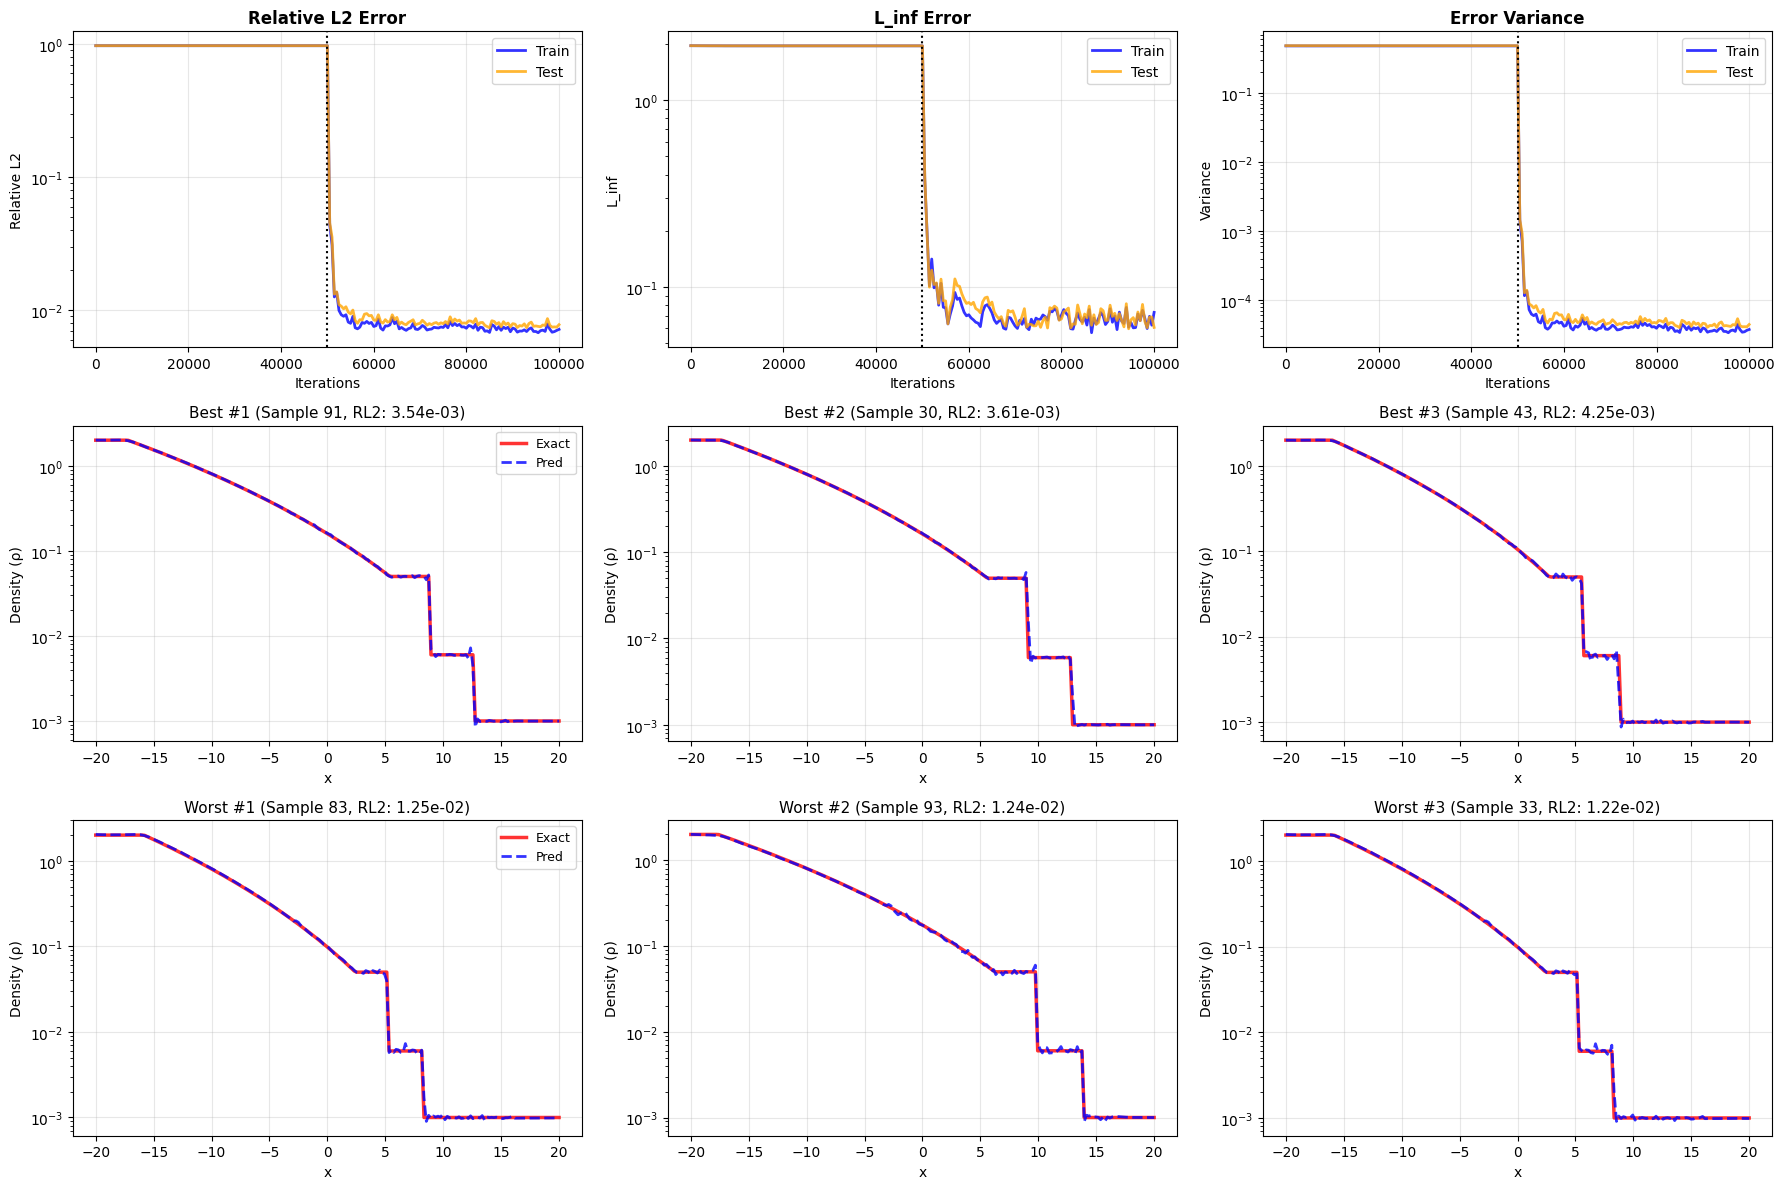


✓ Plot saved as 'summary_metrics_advanced_logarithmic.png'


In [44]:
# --- Configuration for Plotting ---
print("Generating advanced 3x3 summary plot...")

# Ensure we use the correct Test data for the sample plots
X_Test_Plot = X_DN['X_Test'] 

# --- 1. Compute predictions ---
u_pred = apply_fn(params, X_Test_Plot['F'], X_Test_Plot['y'])

# ============================================================
# DENORMALIZE FIRST, THEN COMPUTE ERROR
# ============================================================
# Denormalize predictions and ground truth
u_pred_denorm = denormalize(np.array(u_pred),norm_params)
S_test_denorm = denormalize(np.array(X_Test_Plot['S']),norm_params)

print(f"✓ Denormalized density range: [{np.min(S_test_denorm):.4e}, {np.max(S_test_denorm):.4e}]")

# ============================================================
# COMPUTE ERROR ON PHYSICAL SPACE (NOT LOG SPACE!)
# ============================================================

print("\nComputing errors on physical density...")

# Per-sample error on ACTUAL PHYSICAL DENSITY
norm_diff = np.linalg.norm(S_test_denorm - u_pred_denorm, axis=1)
norm_truth = np.linalg.norm(S_test_denorm, axis=1)
per_sample_error = norm_diff / norm_truth

print(f"  Mean physical error: {np.mean(per_sample_error):.4e}")
print(f"  Min physical error:  {np.min(per_sample_error):.4e}")
print(f"  Max physical error:  {np.max(per_sample_error):.4e}")

# Sort by PHYSICAL error
sorted_indices = np.argsort(per_sample_error)
best_3_indices = sorted_indices[:3]
worst_3_indices = sorted_indices[-3:][::-1]

print(f"\nBest 3 samples: {best_3_indices} with errors {per_sample_error[best_3_indices]}")
print(f"Worst 3 samples: {worst_3_indices} with errors {per_sample_error[worst_3_indices]}")

# ============================================================
# CREATE THE 3x3 PLOT
# ============================================================

# --- 2. Create the 3x3 Plot ---
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

# ================= ROW 1: METRICS =================
# L2 Error
ax = axes[0, 0]
ax.plot(it_log_T, train_L2_real, label='Train', color='blue', alpha=0.8, linewidth=2)
ax.plot(it_log_T, test_L2_real, label='Test', color='orange', alpha=0.8, linewidth=2)
ax.set_title('Relative L2 Error', fontweight='bold', fontsize=12)
ax.set_xlabel('Iterations', fontsize=10)
ax.set_ylabel('Relative L2', fontsize=10)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axvline(x=ngsteps_stage1, color='k', linestyle=':', linewidth=1.5, label='Stage 2')

# L_infinity Error
ax = axes[0, 1]
ax.plot(it_log_T, train_Linf_real, label='Train', color='blue', alpha=0.8, linewidth=2)
ax.plot(it_log_T, test_Linf_real, label='Test', color='orange', alpha=0.8, linewidth=2)
ax.set_title('L_inf Error', fontweight='bold', fontsize=12)
ax.set_xlabel('Iterations', fontsize=10)
ax.set_ylabel('L_inf', fontsize=10)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axvline(x=ngsteps_stage1, color='k', linestyle=':', linewidth=1.5)

# Variance
ax = axes[0, 2]
ax.plot(it_log_T, train_Var_real, label='Train', color='blue', alpha=0.8, linewidth=2)
ax.plot(it_log_T, test_Var_real, label='Test', color='orange', alpha=0.8, linewidth=2)
ax.set_title('Error Variance', fontweight='bold', fontsize=12)
ax.set_xlabel('Iterations', fontsize=10)
ax.set_ylabel('Variance', fontsize=10)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axvline(x=ngsteps_stage1, color='k', linestyle=':', linewidth=1.5)

# ================= ROW 2: BEST SAMPLES (DENORMALIZED) =================
x_spatial = np.array(y_all).flatten() # Spatial grid

for i, idx in enumerate(best_3_indices):
    ax = axes[1, i]
    
    # USE DENORMALIZED DATA
    rho_true = S_test_denorm[idx]
    rho_pred_vals = u_pred_denorm[idx]
    
    ax.plot(x_spatial, rho_true, 'r-', label='Exact', linewidth=2.5, alpha=0.8)
    ax.plot(x_spatial, rho_pred_vals, 'b--', label='Pred', linewidth=2, alpha=0.8)
    ax.set_title(f"Best #{i+1} (Sample {idx}, RL2: {per_sample_error[idx]:.2e})", fontsize=11)
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('Density (ρ)', fontsize=10)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    if i==0: ax.legend(fontsize=9)

# ================= ROW 3: WORST SAMPLES (DENORMALIZED) =================
for i, idx in enumerate(worst_3_indices):
    ax = axes[2, i]
    
    # USE DENORMALIZED DATA
    rho_true = S_test_denorm[idx]
    rho_pred_vals = u_pred_denorm[idx]
    
    ax.plot(x_spatial, rho_true, 'r-', label='Exact', linewidth=2.5, alpha=0.8)
    ax.plot(x_spatial, rho_pred_vals, 'b--', label='Pred', linewidth=2, alpha=0.8)
    ax.set_title(f"Worst #{i+1} (Sample {idx}, RL2: {per_sample_error[idx]:.2e})", fontsize=11)
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('Density (ρ)', fontsize=10)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    if i==0: ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig(f'summary_metrics_advanced_{METHOD}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved as 'summary_metrics_advanced_{METHOD}.png'")

In [45]:
# --- Configuration ---
save_filename = f'results_summary_{METHOD}.npz'

print(f"Saving full results to {save_filename}...")

# ============================================================
# 1. HELPER FOR DENORMALIZATION
# ============================================================
def denormalize_general(data_norm, min_val, max_val, problem_type):
    """
    Generic denormalizer that handles different min/max for Inputs (v) vs Outputs (rho).
    """
    # 1. Linear Un-scaling: [-1, 1] -> [min, max]
    data = (data_norm + 1.0) * (max_val - min_val) / 2.0 + min_val
    
    # 2. Inverse Log Transform (if HPR)
    if problem_type == "HPR":
        data = np.exp(data)
        
    return data

# ============================================================
# 2. DENORMALIZE TEST DATA (PHYSICAL SPACE)
# ============================================================
# Use 'rho' params for Density (S)
S_test_true_physical = denormalize_general(
    np.array(X_Test_Plot['S']), 
    norm_params['rho_min'], 
    norm_params['rho_max'], 
    norm_params['Problem']
)

S_test_pred_physical = denormalize_general(
    np.array(u_pred), 
    norm_params['rho_min'], 
    norm_params['rho_max'], 
    norm_params['Problem']
)

# Use 'v' params for Input Pressure (F) <-- CRITICAL FIX
F_test_physical = denormalize_general(
    np.array(X_Test_Plot['F']), 
    norm_params['v_min'], 
    norm_params['v_max'], 
    norm_params['Problem']
)

print(f"  Denormalized test data:")
print(f"    True density (rho) range: [{np.min(S_test_true_physical):.4e}, {np.max(S_test_true_physical):.4e}]")
print(f"    Input pressure (v) range: [{np.min(F_test_physical):.4e}, {np.max(F_test_physical):.4e}]")

# ============================================================
# 3. PREPARE METRICS ARRAYS
# ============================================================
it_log_np = np.array(it_log_T)

# Normalized Errors
train_L2_np = np.array(train_L2)
test_L2_np = np.array(test_L2)
train_Linf_np = np.array(train_Linf)
test_Linf_np = np.array(test_Linf)
train_Var_np = np.array(train_Var)
test_Var_np = np.array(test_Var)

# Real (Physical) Errors (Added from previous steps)
train_L2_real_np = np.array(train_L2_real)
test_L2_real_np = np.array(test_L2_real)
train_Linf_real_np = np.array(train_Linf_real)
test_Linf_real_np = np.array(test_Linf_real)
train_Var_real_np = np.array(train_Var_real)
test_Var_real_np = np.array(test_Var_real)

# Spatial & Analysis
x_spatial_np = np.array(y_all).flatten()
per_sample_error_np = np.array(per_sample_error) # Ensure this variable is available

# ============================================================
# 4. SAVE TO .NPZ
# ============================================================
np.savez(
    save_filename,
    
    # --- Training History (Normalized) ---
    iterations=it_log_np,
    train_L2=train_L2_np,
    test_L2=test_L2_np,
    train_Linf=train_Linf_np,
    test_Linf=test_Linf_np,
    train_Var=train_Var_np,
    test_Var=test_Var_np,
    
    # --- Training History (Real/Physical) [NEW] ---
    train_L2_real=train_L2_real_np,
    test_L2_real=test_L2_real_np,
    train_Linf_real=train_Linf_real_np,
    test_Linf_real=test_Linf_real_np,
    train_Var_real=train_Var_real_np,
    test_Var_real=test_Var_real_np,
    
    stage1_steps=ngsteps_stage1,
    
    # --- Physical Data Predictions ---
    x_spatial=x_spatial_np,
    S_true=S_test_true_physical,
    S_pred=S_test_pred_physical,
    F_inputs=F_test_physical,
    
    # --- Analysis ---
    per_sample_error=per_sample_error_np,
    best_indices=np.array(best_3_indices),
    worst_indices=np.array(worst_3_indices),
    
    # --- Metadata ---
    norm_params_rho_min=norm_params['rho_min'],
    norm_params_rho_max=norm_params['rho_max'],
    norm_params_v_min=norm_params['v_min'],
    norm_params_v_max=norm_params['v_max'],
    norm_params_Problem=norm_params['Problem']
)

print(f"✓ Data successfully saved to {save_filename}")
print(f"  - Included both Normalized and Physical error histories.")
print(f"  - Inputs (F) denormalized using Pressure (v) statistics.")
print(f"  - Outputs (S) denormalized using Density (rho) statistics.")

Saving full results to results_summary_logarithmic.npz...
  Denormalized test data:
    True density (rho) range: [1.0000e-03, 2.0000e+00]
    Input pressure (v) range: [inf, inf]
✓ Data successfully saved to results_summary_logarithmic.npz
  - Included both Normalized and Physical error histories.
  - Inputs (F) denormalized using Pressure (v) statistics.
  - Outputs (S) denormalized using Density (rho) statistics.


/tmp/ipykernel_568278/3315251081.py:18: RuntimeWarning: overflow encountered in exp
  data = np.exp(data)
